# Dimensionality Reduction

## 6. Unsupervised Methods - Non-Linear Embedding 

### 1. Isomap 
    -> 원래 데이터에서 매니폴드를 고려하여 거리 정보를 잘 보존하면서 변수의 차원을 줄이는 방법.  
     매니폴드 : 아래 그림과 같이, 점과 점사이의 거리가 유클리디언 거리가 아닌 다양체

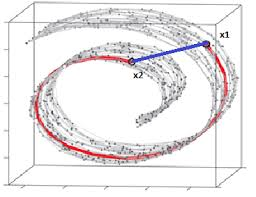

In [3]:
from IPython.display import Image
from IPython.core.display import HTML
Image(filename="C:/Users/dsba/Downloads/ba/iso.jpg",width=200,height=450)

#### 1-1. Isomap 특징  

   1. 공간의 차원을 줄여도 점과 점사이 거리의 상대성을 유지시킨다.    
   2. swiss roll, 위 그림처럼 다차원의 공간의 점들을 저차원에서 펴준다는 느낌으로 매핑.
   3. MDS 기본 과정에 들어가기에 앞서 거리를 계산하는 방법을 다르게 정의할 뿐.  

#### 1-2. Isomap 과정  

   1. 먼저 각 점들에 대해 neighbor들을 이어 그래프를 형성(보통 입실론을 설정하여 그보다 낮은 거리 점들을 연결 후, 나머지에 대해 knn 기준으로 연결)    
   2. 연결된 그래프를 기준으로 최단거리 계산(dijkstra 등의 알고리즘 이용).
   3. 계산된 거리 행렬을 이용해 그 상대적 거리정보를 가장 잘 보존하는 방향으로 (MDS) 차원을 축소.  

#### 1-3. code 구현

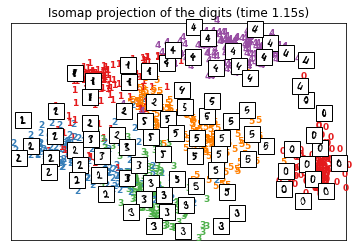

In [2]:
%matplotlib inline

from sklearn import (datasets,random_projection)
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import Isomap

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    
    if title is not None:
        plt.title(title)
        
t0 = time()
sk_isomap = Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(X)
plot_embedding(sk_isomap,"Isomap projection of the digits (time %.2fs)" %(time() - t0))

In [9]:
sk_isomap

array([[-67.86282017, -22.8497804 ],
       [ 45.77938502,  39.29629015],
       [ 28.9622598 ,  16.6814007 ],
       ...,
       [-43.73857306,  61.24712671],
       [-40.38641577,  65.71487253],
       [-62.91252726, -14.50359928]])

### 2. LLE(Locally Linear Embedding) 
    -> 원래 데이터에서 객체들의 기하학적 정보를 잘 보존하면서 변수의 차원을 줄이는 방법.  
     객체를 주변의 객체들의 선형결합으로 나타내고, 그 결합을 보존하면서 차원을 축소.

#### 2-1. LLE 과정  

   1. 먼저 각 객체들의 이웃을 설정하고, 그 객체를 이웃들의 선형결합으로 나타낸다.    
   2. 이웃들의 선형결합이 최선이 되도록, 그 객체와 결합값과의 차이 합을 최소화 학습한다.$$E(W)=\sum_{i} \left\vert (x_i - \sum_{j}W_{ij}*x_j) \right\vert$$
   3. 그렇게 결정된 W를 고정시킨 후, 새로운 차원에서의 좌표 y를 찾아냄.  $$\sum_{i} \left\vert (y_i - \sum_{j}W_{ij}*y_j) \right\vert$$  
   
   
   4. 위의 식을 최소화하는 문제를 라그랑조 법을 이용한 뒤, 고유값 분해를 진행.  
   5. 고유값이 작은것 부터 원하는 차원의 수만큼 선택한 후, 객체 값들을 축 씩 하나씩 구해간다.  
   
#### 2-2. LLE 특징  

#### 2-3. code 구현  

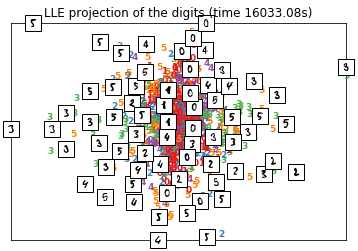

In [12]:
from scipy.sparse.linalg import eigsh

def LLE(X, n_neighbors, n_components):

    x_matrix = np.asmatrix(X).T
    D, N = x_matrix.shape

    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    distance = np.asmatrix(D)

    index=np.argsort(distance,axis=0)
    neighborhood = index[1:(n_neighbors+1),:]

    W = np.zeros((n_neighbors,N))
    tol = 1e-3


    # for variables
    for i in range(N):
        z = x_matrix[:, np.array(neighborhood[:,i]).reshape(-1)] - np.tile(x_matrix[:,i],(1,n_neighbors)) # shift ith pt to origi
        C = z.T*z # local covariance
        C = C + np.eye(n_neighbors) * tol * np.trace(C)
        I = np.ones((n_neighbors))
        W[:,i] = np.linalg.solve(np.array(C),I)
        W[:,i] = W[:,i]/sum(W[:,i])


    M = np.eye(N)  # M = (I-W)' (I-W)

    for i in range(N):
        w = W[:, i]
        j = neighborhood[:, i]
        M[i, j] = M[i, j] - np.asmatrix(w).T
        M[j, i] = M[j, i] - np.asmatrix(w).T
        M[j, j] = M[j, j] + np.asmatrix(w*w.T).T

    eigenvals, Y = eigsh(M, n_components + 1, tol=1e-3, sigma=0.0, maxiter = 100)

    return Y[:, 1:], np.sum(eigenvals[1:])

embedding, _ = LLE(X=X, n_neighbors=n_neighbors, n_components=2)

plot_embedding(embedding,"LLE projection of the digits (time %.2fs)" %(time() - t0))

### 3. SNE(Stochastic Neighbor Embedding) 
    -> i가 주어졌을때 j를 이웃으로 뽑는 확률분포가, 고차원일때와 저차원일때 가장 유사하도록 하면서 변수의 차원을 줄이는 방법.  
     즉, 객체들간의 구조, 확률적 분포를 최대한으로 보존하도록 임베딩.

### + KLD vs JSD
**KLD**(Kullback Leibler Divergence)  
 -> 확률분포와 그 확률분포의 근사 분포간의 정보 손실량의 기댓값을 계산하는 척도.  
   즉, 얼마나 두 분포가 비슷하게 생겼는지. $$D_{KL}(p||q) = E[logp(x)-logq(x)] = \sum_{i=1}^N p(x_i)*log{p(x_i)\over q(x_i)}$$
따라서 symmetric하지 않으므로 KLD(p||q) != KLD(q||p)  // 그리고 p와 q가 완전히 같으면 이 수치는 0이 된다.  

  
  

**JSD**(Jensen-Shannon Divergence)  
     -> KSD를 symmetric하게 만든 수치이다.$$JSD(p||q) = {1\over2} * D_{KL}(p||m) +{1\over2} * D_{KL}(q||m)  $$  
     $$\text{where, }  m={1\over2}*(p+q)$$  
   위의 작업을 통해 JSD(p,q)=JSD(q,p) 가 되도록 symmetric한 값으로 p와 q가 같으면 0이 된다.

#### 3-1. SNE 과정  

   1. 모든 객체에 대해서, 서로를 이웃으로 선택하는 확률분포를 계산한다.  
   2. 그리고 임의의 저차원에서 서로를 이웃으로 선택하는 확률분포 함수를 설정한다.  
   3. 1,2번의 두 확률분포의 차이를 KLD를 이용해서 설정한다.  
   4. 그 KLD를 최소화하도록 미분을 하여 Gradient를 구한다.  
   5. 반복 매핑을 하면서 수렴점을 찾음. $$4\sum_{j} (y_j-y_i)(p_{ij}-q_{ij})$$  
   $$p_{ij} = {p_{j\vert i}+p_{i\vert j} \over 2n }$$
   
#### 3-2. SNE 특징  
   1. outlier 발생시 큰 값이 발생하므로, 이를 방지하기 위해 서로를 선택하는 경우를 합해서 계산.  
   2. local minima에 빠질 수 있고, 시간이 오래 걸림.  
   
#### 3-3. TSNE 특징  
   
   1. Crowding 문제(cluster가 있는 등의 근접한 점들을 분리하는 것은 어려움, 근접 점을 기준으로 하면 cluster 형성에 방해)를 해결하기 위함.  
       즉, 유사하지 않은 점을 가까운 거리로 설정한 경우, 척력이 작용해서 오류를 줄임.  
   2. 두 점 간의 유사도를 gaussain이 아닌, t-distribution을 이용(멀리 떨어진 점에 대한 확률 증가위해.)  

#### 3-4. code 구현  

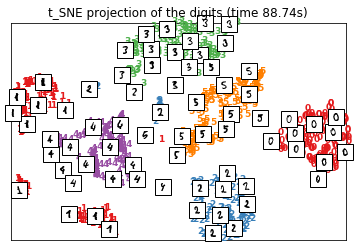

In [3]:
import numpy as np


def neg_distance(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D


def softmax(X):
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    np.fill_diagonal(e_x, 0.)

    e_x = e_x + 1e-8

    return e_x / e_x.sum(axis=1).reshape([-1, 1])


def calc_prob_matrix(distances, sigmas=None):
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)


def _perplexity(prob_matrix):
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity


def perplexity(distances, sigmas):
    return _perplexity(calc_prob_matrix(distances, sigmas))



def binary_search(fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess


def find_optimal_sigmas(distances, target_perplexity):
    sigmas = []
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)


def p_conditional_to_joint(P):
    return (P + P.T) / (2. * P.shape[0])

def p_joint(X, target_perplexity):
    distances = neg_distance(X)
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    p_conditional = calc_prob_matrix(distances, sigmas)
    P = p_conditional_to_joint(p_conditional)
    return P

def q_joint(Y):
    inv_distances = neg_distance(Y)
    distances = np.power(1. - inv_distances, -1)
    np.fill_diagonal(distances, 0.)
    return distances / np.sum(distances), distances


def tsne_grad(P, Q, Y, distances):
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)

    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    distances_expanded = np.expand_dims(distances, 2)
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad



def t_SNE(X, num_component, num_iters = 500, learning_rate = 10., momentum = .9):

    Y = np.random.normal(0., 0.0001,[X.shape[0], num_component])
    P = p_joint(X, 20)

    # Initialise past values (used for momentum)
    if momentum:
        Y_m2 = Y
        Y_m1 = Y

    # Start gradient descent loop
    for i in range(num_iters):

        # Get Q and distances
        Q, distances = q_joint(Y)

        # Cal gradients
        grads = tsne_grad(P, Q, Y, distances)

        # Update Y
        Y = Y - learning_rate * grads
        if momentum:
            Y += momentum * (Y_m1 - Y_m2)
            # Update previous Y's for momentum
            Y_m2 = Y_m1
            Y_m1 = Y

    return Y

embedding = t_SNE(X = X, num_component = 2)

plot_embedding(embedding,"t_SNE projection of the digits (time %.2fs)" %(time() - t0))